In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import folium
import os
import json, requests
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

### Foursquare API Credentials

In [3]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = ''

In [4]:
address = 'calle de atocha'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.1799239 -2.3345706


### 1.º Step) Upload map of Madrid

In [5]:
madrid_lat_long = [40.4165000, -3.7025600]
map_madrid = folium.Map(location=madrid_lat_long, zoom_start=10)

# add markers to map
folium.CircleMarker([madrid_lat_long[0], madrid_lat_long[1]],
                    radius=5,
                    popup = 'Madrid',
                    color='blue',
                    fill=True,
                    fill_color='#3186cc',
                    fill_opacity=0.7).add_to(map_madrid)  
    
map_madrid

### 2.º step) Defining some functions

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getDfFoursquareNearbyVenues(lat = madrid_lat_long[0], lng = madrid_lat_long[1] ,limit = 500, radius = 1000):
    url = 'https://api.foursquare.com/v2/venues/explore'
    params = dict(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        v=VERSION,
        ll='%s,%s' % (lat, lng),
        radius='%s' % (radius),
        limit=limit
    )
    
    resp = requests.get(url=url, params=params)
    data = json.loads(resp.text)
    venues = data['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues) # flatten JSON
    print('Found %s nearby venues at %s,%s' % (len(nearby_venues.index), lat, lng))
    
    # filter columns 
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    if (len(nearby_venues.index) > 0): 
        nearby_venues = nearby_venues.loc[:, filtered_columns]
        # filter the category for each row
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
        # clean columns
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
        
    return nearby_venues

def getDfFoursquareByNeighborhood(neighborhoodName, neighborhoodLat, neighborhoodLng, radius = 500):
    nearby_venues = getDfFoursquareNearbyVenues(lat = neighborhoodLat, lng = neighborhoodLng, radius = radius ); # A Panda Dataframe
    print('Getting %s nearby venues at %s' % (len(nearby_venues.index), neighborhoodName))
    venues = nearby_venues.rename(columns={'name': 'Venue','lat': 'Venue Latitude', 'lng': 'Venue Longitude', 'categories': 'Venue Category'})
    venues['Neighborhood'] = neighborhoodName
    venues['Neighborhood Latitude'] = neighborhoodLat
    venues['Neighborhood Longitude'] = neighborhoodLng    
    return venues

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    nearbyVenues = pd.DataFrame([], columns = ['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood','Neighborhood Latitude','Neighborhood Longitude'])
    for name, lat, lng in zip(names, latitudes, longitudes):
        items = getDfFoursquareByNeighborhood(name, lat, lng, radius)
        print('Adding %s nearby venues at %s' % (len(items.index), name))
        nearbyVenues = nearbyVenues.append(items, ignore_index=True, sort=False)
        print('Total venues found: %s' % len(nearbyVenues.index))
     
    return nearbyVenues

#### The following code will give us the nearest venues in Madrid center (lat:40.4165, log:-3.70256)

In [7]:
df_venues = getDfFoursquareNearbyVenues()
df_venues

Found 100 nearby venues at 40.4165,-3.70256


,name,categories,lat,lng
0,Puerta del Sol,Plaza,40.417027,-3.703443
1,InClan Brutal Bar,Tapas Restaurant,40.415023,-3.701864
2,Rosi La Loca,Tapas Restaurant,40.415821,-3.702955
3,Club del Gourmet Corte Ingles,Gourmet Shop,40.417497,-3.704686
4,La Pulpería de Victoria,Seafood Restaurant,40.416506,-3.701709
...,...,...,...,...
95,2060 The Newton Hostel,Hostel,40.411861,-3.703511
96,Gran Meliá Palacio de los Duques *****,Hotel,40.419835,-3.709494
97,Kuoco 360,Restaurant,40.421842,-3.698456
98,La Pescadería,Restaurant,40.422883,-3.703208


In [8]:
df_venues.categories.value_counts()

Hotel                       10
Hostel                       7
Plaza                        7
Restaurant                   5
Café                         5
Spanish Restaurant           3
Art Museum                   3
Bookstore                    3
Electronics Store            2
Italian Restaurant           2
Market                       2
Wine Bar                     2
Mediterranean Restaurant     2
Clothing Store               2
Theater                      2
Pastry Shop                  2
Cosmetics Shop               2
Gourmet Shop                 2
Tapas Restaurant             2
Church                       1
Monument / Landmark          1
Indie Movie Theater          1
Gift Shop                    1
Gym                          1
Pizza Place                  1
Burger Joint                 1
Coffee Shop                  1
Argentinian Restaurant       1
Museum                       1
Rental Service               1
Ice Cream Shop               1
Seafood Restaurant           1
Historic

#### Remember we wanted to start a new business by open a new restaurant, so it's important to know how many there are and how are they distributed in the center.

In [9]:
df_restaurant = df_venues.loc[df_venues.categories.str.contains('Restaurant'),:]
df_restaurant

,name,categories,lat,lng
1,InClan Brutal Bar,Tapas Restaurant,40.415023,-3.701864
2,Rosi La Loca,Tapas Restaurant,40.415821,-3.702955
4,La Pulpería de Victoria,Seafood Restaurant,40.416506,-3.701709
11,La Cabaña Argentina,Argentinian Restaurant,40.415696,-3.698974
13,TAKOS,Mexican Restaurant,40.418938,-3.703748
14,Eat Is Wok,Asian Restaurant,40.415553,-3.700305
20,Museo del Jamón,Spanish Restaurant,40.416343,-3.705682
21,Arrocería Marina Ventura,Paella Restaurant,40.415353,-3.698941
41,El Rincon de Esteban,Spanish Restaurant,40.415803,-3.697743
42,Trattoria Malatesta,Italian Restaurant,40.416788,-3.707182


#### Defining venues that could be interesting for turists

In [10]:
venue_options = ['Plaza', 'Art Museum', 'Monument / Landmark', 'Art Gallery', 'Church', 'Palace', 'Opera House', 'Historic Site', 'Theater', 'Movie Theater', 'Indie Movie Theater', 'Garden']
df_no_restaurant = df_venues[df_venues['categories'].isin(venue_options)]
df_no_restaurant

,name,categories,lat,lng
0,Puerta del Sol,Plaza,40.417027,-3.703443
6,Plaza de Santa Ana,Plaza,40.414631,-3.701033
10,Teatro Español,Theater,40.414723,-3.700615
22,Palacio de Gaviria,Art Museum,40.417139,-3.706044
24,Plaza Santa Cruz,Plaza,40.415063,-3.705661
30,Plaza Mayor,Plaza,40.415527,-3.707506
37,Teatro de La Zarzuela,Theater,40.417184,-3.697055
47,Plaza del Callao,Plaza,40.420145,-3.705763
49,Espacio Fundación Telefónica,Art Museum,40.420392,-3.701617
60,Círculo de Bellas Artes,Monument / Landmark,40.418486,-3.696612


In [11]:
#This will be important to define the number of clusters
len(df_no_restaurant)

17

#### Visualizing on the map where all restaurants are located (color blue) and the rest of venues (color red) on the center:

In [12]:
for lat, lng, label in zip(df_restaurant.lat, df_restaurant.lng, df_restaurant.categories):
    folium.CircleMarker([lat, lng],
                        radius=3,
                        popup = label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7).add_to(map_madrid)

for lat, lng, label in zip(df_no_restaurant.lat, df_no_restaurant.lng, df_no_restaurant.categories):
    folium.CircleMarker([lat, lng],
                        radius=7,
                        popup = label,
                        color='red',
                        fill=True,
                        fill_color='#F08080',
                        fill_opacity=0.7).add_to(map_madrid)
map_madrid

## It's important to check the restaurants nearby each tourist venue located on the center!

#### Using the function getNearbyVenues we just defined above we'll get that data

In [13]:
df_nearby_venues = getNearbyVenues(df_no_restaurant['name'], df_no_restaurant['lat'], df_no_restaurant['lng'])

Found 62 nearby venues at 40.4170267569777,-3.703442763596807
Getting 62 nearby venues at Puerta del Sol
Adding 62 nearby venues at Puerta del Sol
Total venues found: 62
Found 100 nearby venues at 40.41463076310542,-3.7010325869307574
Getting 100 nearby venues at Plaza de Santa Ana
Adding 100 nearby venues at Plaza de Santa Ana
Total venues found: 162
Found 100 nearby venues at 40.41472295273593,-3.7006151566523107
Getting 100 nearby venues at Teatro Español
Adding 100 nearby venues at Teatro Español
Total venues found: 262
Found 75 nearby venues at 40.41713929663129,-3.7060442727377425
Getting 75 nearby venues at Palacio de Gaviria
Adding 75 nearby venues at Palacio de Gaviria
Total venues found: 337
Found 100 nearby venues at 40.415063266025314,-3.705661389771447
Getting 100 nearby venues at Plaza Santa Cruz
Adding 100 nearby venues at Plaza Santa Cruz
Total venues found: 437
Found 87 nearby venues at 40.415526598647354,-3.7075061894121037
Getting 87 nearby venues at Plaza Mayor
Addi

In [14]:
df_nearby_venues

,Venue,Venue Category,Venue Latitude,Venue Longitude,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Puerta del Sol,Plaza,40.417027,-3.703443,Puerta del Sol,40.417027,-3.703443
1,Club del Gourmet Corte Ingles,Gourmet Shop,40.417497,-3.704686,Puerta del Sol,40.417027,-3.703443
2,Rosi La Loca,Tapas Restaurant,40.415821,-3.702955,Puerta del Sol,40.417027,-3.703443
3,La Pulpería de Victoria,Seafood Restaurant,40.416506,-3.701709,Puerta del Sol,40.417027,-3.703443
4,Apple Puerta del Sol,Electronics Store,40.416996,-3.702243,Puerta del Sol,40.417027,-3.703443
...,...,...,...,...,...,...,...
1463,Tulup Paletas Mexicanas,Ice Cream Shop,40.410481,-3.706657,Basílica de San Miguel,40.414138,-3.709685
1464,Muralla musulmana de Madrid,Historic Site,40.414881,-3.714990,Basílica de San Miguel,40.414138,-3.709685
1465,Marula Café,Music Venue,40.413439,-3.713393,Basílica de San Miguel,40.414138,-3.709685
1466,El Bombín de Sabina,Tapas Restaurant,40.410268,-3.711838,Basílica de San Miguel,40.414138,-3.709685


#### From all venues categories it matters the restaurant ones:

In [15]:
df_nearby_restaurants = df_nearby_venues[df_nearby_venues['Venue Category'].str.contains('Restaurant')]
df_nearby_restaurants

,Venue,Venue Category,Venue Latitude,Venue Longitude,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
2,Rosi La Loca,Tapas Restaurant,40.415821,-3.702955,Puerta del Sol,40.417027,-3.703443
3,La Pulpería de Victoria,Seafood Restaurant,40.416506,-3.701709,Puerta del Sol,40.417027,-3.703443
6,TAKOS,Mexican Restaurant,40.418938,-3.703748,Puerta del Sol,40.417027,-3.703443
9,Museo del Jamón,Spanish Restaurant,40.416343,-3.705682,Puerta del Sol,40.417027,-3.703443
15,InClan Brutal Bar,Tapas Restaurant,40.415023,-3.701864,Puerta del Sol,40.417027,-3.703443
...,...,...,...,...,...,...,...
1453,Casa Amadeo - Los Caracoles,Spanish Restaurant,40.410538,-3.707307,Basílica de San Miguel,40.414138,-3.709685
1456,Xentes,Spanish Restaurant,40.409982,-3.710378,Basílica de San Miguel,40.414138,-3.709685
1459,La Taquería de Birra,Mexican Restaurant,40.411605,-3.713569,Basílica de San Miguel,40.414138,-3.709685
1460,Malacatín,Spanish Restaurant,40.410378,-3.707629,Basílica de San Miguel,40.414138,-3.709685


In [16]:
df_nearby_restaurants.groupby('Neighborhood').count()

,Venue,Venue Category,Venue Latitude,Venue Longitude,Neighborhood Latitude,Neighborhood Longitude
Neighborhood,,,,,,
Basílica de San Miguel,37,37,37,37,37,37
Cine Doré,35,35,35,35,35,35
Círculo de Bellas Artes,15,15,15,15,15,15
Espacio Fundación Telefónica,25,25,25,25,25,25
Museo Thyssen-Bornemisza,24,24,24,24,24,24
Palacio de Gaviria,14,14,14,14,14,14
Plaza Mayor,25,25,25,25,25,25
Plaza Santa Cruz,29,29,29,29,29,29
Plaza de Antón Martín,35,35,35,35,35,35


In [17]:
print('There are {} uniques categories.'.format(len(df_nearby_restaurants['Venue Category'].unique())))

There are 27 uniques categories.


### Use folium to visualize the geographic details

#### Green points represent the restaurants, red points represent the tourist attractions and the blue point defines the Madrid Center

In [18]:
madrid_lat_long = [40.4165000, -3.7025600]
new_map_madrid = folium.Map(location=madrid_lat_long, zoom_start=10)

# add markers to map
folium.CircleMarker([madrid_lat_long[0], madrid_lat_long[1]],
                    radius=5,
                    popup = 'Madrid',
                    color='blue',
                    fill=True,
                    fill_color='#3186cc',
                    fill_opacity=0.7).add_to(new_map_madrid)

# adding interesting monuments for turists:
for lat, lng, label in zip(df_no_restaurant.lat, df_no_restaurant.lng, df_no_restaurant.categories):
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup = label,
                        color='red',
                        fill=True,
                        fill_color= '#F08080',
                        fill_opacity=0.7).add_to(new_map_madrid)
    
# adding restaurant marks near those monuments:
for lat, lng, label in zip(df_nearby_restaurants['Venue Latitude'], df_nearby_restaurants['Venue Longitude'], df_nearby_restaurants['Venue Category']):
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup = label,
                        color='green',
                        fill=True,
                        fill_color='#ADFF2F',
                        fill_opacity=0.7).add_to(new_map_madrid)


    
new_map_madrid

### Visualize graphically the amount of types of restaurants in Madrid Center

Text(0, 0.5, 'Total')

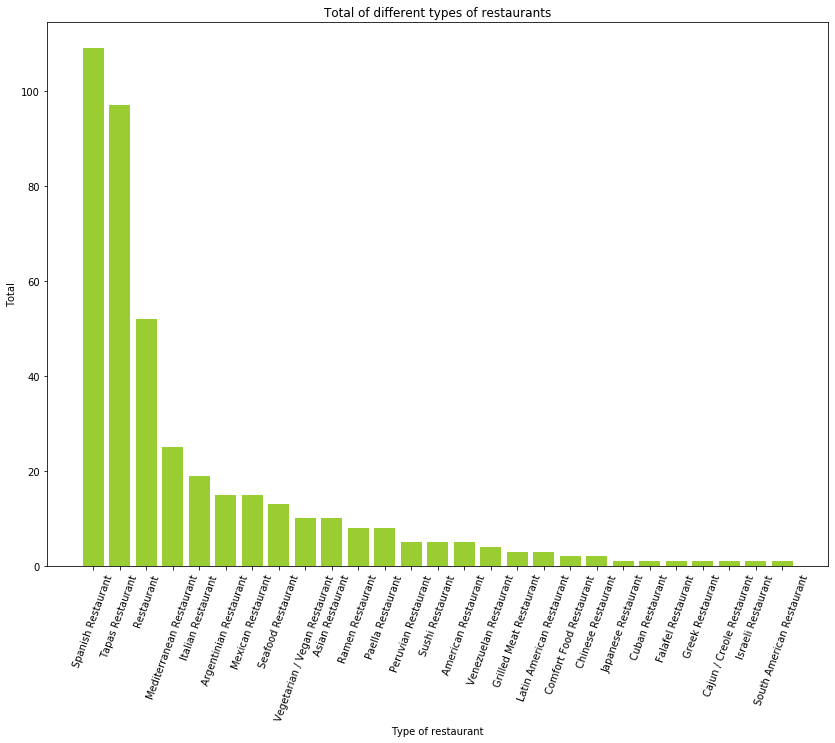

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(14,10))
ax.bar(df_nearby_restaurants['Venue Category'].value_counts().index, df_nearby_restaurants['Venue Category'].value_counts(), color='yellowgreen')
ax.set_title('Total of different types of restaurants')
ax.tick_params(axis='x', rotation=70)
ax.set_xlabel('Type of restaurant')
ax.set_ylabel('Total')

### Preparing data for unsupervised learning

In [20]:
# one hot encoding
dfVenues_onehot = pd.get_dummies(df_nearby_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dfVenues_onehot['Neighborhood'] = df_nearby_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dfVenues_onehot.columns[-1]] + list(dfVenues_onehot.columns[:-1])
dfVenues_onehot = dfVenues_onehot[fixed_columns]

dfVenues_onehot.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Falafel Restaurant,Greek Restaurant,...,Peruvian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant
2,Puerta del Sol,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Puerta del Sol,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,Puerta del Sol,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Puerta del Sol,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15,Puerta del Sol,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
dfVenues_grouped = dfVenues_onehot.groupby('Neighborhood').mean().reset_index()
dfVenues_grouped

,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Falafel Restaurant,Greek Restaurant,...,Peruvian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant
0,Basílica de San Miguel,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.027027,0.081081,0.000000,0.000000,0.297297,0.000000,0.378378,0.081081,0.000000
1,Cine Doré,0.000000,0.057143,0.028571,0.000000,0.000000,0.000000,0.028571,0.00,0.000000,...,0.028571,0.000000,0.228571,0.000000,0.000000,0.400000,0.028571,0.057143,0.000000,0.000000
2,Círculo de Bellas Artes,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.200000,0.066667,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000
3,Espacio Fundación Telefónica,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04,0.000000,...,0.000000,0.000000,0.160000,0.040000,0.000000,0.080000,0.000000,0.160000,0.120000,0.000000
4,Museo Thyssen-Bornemisza,0.000000,0.041667,0.041667,0.000000,0.000000,0.041667,0.000000,0.00,0.000000,...,0.000000,0.000000,0.291667,0.000000,0.000000,0.291667,0.000000,0.041667,0.000000,0.041667
5,Palacio de Gaviria,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.071429,0.071429,0.071429,0.000000,0.214286,0.000000,0.428571,0.000000,0.000000
6,Plaza Mayor,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.040000,0.040000,0.000000,0.000000,0.320000,0.000000,0.440000,0.000000,0.000000
7,Plaza Santa Cruz,0.034483,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.034483,0.034483,0.034483,0.000000,0.310345,0.000000,0.344828,0.034483,0.000000
8,Plaza de Antón Martín,0.000000,0.057143,0.028571,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.028571,0.000000,0.228571,0.028571,0.000000,0.257143,0.028571,0.085714,0.000000,0.028571
9,Plaza de Isabel II,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.00,0.000000,...,0.000000,0.076923,0.076923,0.076923,0.000000,0.230769,0.000000,0.307692,0.000000,0.000000


In [22]:
num_top_venues = 5

for hood in dfVenues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = dfVenues_grouped[dfVenues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Basílica de San Miguel----
                           venue  freq
0               Tapas Restaurant  0.38
1             Spanish Restaurant  0.30
2  Vegetarian / Vegan Restaurant  0.08
3                     Restaurant  0.08
4             Mexican Restaurant  0.05


----Cine Doré----
                      venue  freq
0        Spanish Restaurant  0.40
1                Restaurant  0.23
2  Mediterranean Restaurant  0.09
3          Tapas Restaurant  0.06
4    Argentinian Restaurant  0.06


----Círculo de Bellas Artes----
                venue  freq
0  Spanish Restaurant  0.33
1          Restaurant  0.20
2   Paella Restaurant  0.07
3    Asian Restaurant  0.07
4  Seafood Restaurant  0.07


----Espacio Fundación Telefónica----
                           venue  freq
0               Tapas Restaurant  0.16
1                     Restaurant  0.16
2  Vegetarian / Vegan Restaurant  0.12
3             Italian Restaurant  0.12
4       Mediterranean Restaurant  0.12


----Museo Thyssen-Bornemisza----
 

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
dfVenues_sorted = pd.DataFrame(columns=columns)
dfVenues_sorted['Neighborhood'] = dfVenues_grouped['Neighborhood']

for ind in np.arange(dfVenues_grouped.shape[0]):
    dfVenues_sorted.iloc[ind, 1:] = return_most_common_venues(dfVenues_grouped.iloc[ind, :], num_top_venues)

dfVenues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Basílica de San Miguel,Tapas Restaurant,Spanish Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Mexican Restaurant,American Restaurant,Italian Restaurant,Mediterranean Restaurant,Ramen Restaurant,Chinese Restaurant
1,Cine Doré,Spanish Restaurant,Restaurant,Mediterranean Restaurant,Tapas Restaurant,Argentinian Restaurant,Sushi Restaurant,Asian Restaurant,Cuban Restaurant,Peruvian Restaurant,Paella Restaurant
2,Círculo de Bellas Artes,Spanish Restaurant,Restaurant,Mediterranean Restaurant,Argentinian Restaurant,Asian Restaurant,Italian Restaurant,Seafood Restaurant,Paella Restaurant,Mexican Restaurant,Venezuelan Restaurant
3,Espacio Fundación Telefónica,Tapas Restaurant,Restaurant,Mediterranean Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Argentinian Restaurant,Spanish Restaurant,Falafel Restaurant,Israeli Restaurant,Seafood Restaurant
4,Museo Thyssen-Bornemisza,Spanish Restaurant,Restaurant,Mediterranean Restaurant,Venezuelan Restaurant,Tapas Restaurant,Argentinian Restaurant,Asian Restaurant,Italian Restaurant,Comfort Food Restaurant,Paella Restaurant


# Clusters

In [25]:
from sklearn.cluster import KMeans

In [26]:
# set number of clusters
kclusters = 14

dfVenues_clustering = dfVenues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfVenues_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:14]

array([ 1,  6,  5,  8,  0,  4, 10,  1, 13, 11,  2,  9,  7,  3],
      dtype=int32)

In [27]:
# add clustering labels
#dfVenues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

dfVenues_merged = df_nearby_restaurants

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dfVenues_merged = dfVenues_merged.join(dfVenues_sorted.set_index('Neighborhood'), on='Neighborhood')

dfVenues_merged.head() # check the last columns!

,Venue,Venue Category,Venue Latitude,Venue Longitude,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Rosi La Loca,Tapas Restaurant,40.415821,-3.702955,Puerta del Sol,40.417027,-3.703443,Tapas Restaurant,Ramen Restaurant,Argentinian Restaurant,Spanish Restaurant,Asian Restaurant,Seafood Restaurant,Italian Restaurant,Paella Restaurant,Mexican Restaurant,Comfort Food Restaurant
3,La Pulpería de Victoria,Seafood Restaurant,40.416506,-3.701709,Puerta del Sol,40.417027,-3.703443,Tapas Restaurant,Ramen Restaurant,Argentinian Restaurant,Spanish Restaurant,Asian Restaurant,Seafood Restaurant,Italian Restaurant,Paella Restaurant,Mexican Restaurant,Comfort Food Restaurant
6,TAKOS,Mexican Restaurant,40.418938,-3.703748,Puerta del Sol,40.417027,-3.703443,Tapas Restaurant,Ramen Restaurant,Argentinian Restaurant,Spanish Restaurant,Asian Restaurant,Seafood Restaurant,Italian Restaurant,Paella Restaurant,Mexican Restaurant,Comfort Food Restaurant
9,Museo del Jamón,Spanish Restaurant,40.416343,-3.705682,Puerta del Sol,40.417027,-3.703443,Tapas Restaurant,Ramen Restaurant,Argentinian Restaurant,Spanish Restaurant,Asian Restaurant,Seafood Restaurant,Italian Restaurant,Paella Restaurant,Mexican Restaurant,Comfort Food Restaurant
15,InClan Brutal Bar,Tapas Restaurant,40.415023,-3.701864,Puerta del Sol,40.417027,-3.703443,Tapas Restaurant,Ramen Restaurant,Argentinian Restaurant,Spanish Restaurant,Asian Restaurant,Seafood Restaurant,Italian Restaurant,Paella Restaurant,Mexican Restaurant,Comfort Food Restaurant


In [28]:
# create map
map_clusters = folium.Map(location=madrid_lat_long, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfVenues_merged['Neighborhood Latitude'], dfVenues_merged['Neighborhood Longitude'], dfVenues_merged['Neighborhood'], dfVenues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

KeyError: 'Cluster Labels'

## Cluster 1 (label 0) - Teatro de La Zarzuela

#### Based on this cluster we can see that there aren't any mexican, american, greek, japonese or vegetarian/vegan restaurants nearby the Theater "Teatro de La Zarzuela" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_1 =dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 0].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_1.head()

## Cluster 2 (label 1) - Plaza Mayor

#### Based on this cluster we can see that there aren't any mediterranean, greek, seafood or vegetarian/vegan restaurants nearby the "Plaza Mayor" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_2 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 1].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_2.head()

## Cluster 3 (label 2) - Plaza de Antón Martin

#### Based on this cluster we can see that there aren't any mexican, american, greek, japonese or vegetarian/vegan restaurant nearby the "Plaza de Antón Martin" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_3 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 2].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_3.head()

## Cluster 4 (label 3) - Plaza del Callao

#### Based on this cluster we can see that there aren't any argentinian, greek, japonese, american or vegetarian/vegan restaurant nearby the "Plaza del Callao" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_4 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 3].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_4.head()

## Cluster 5 (label 4) - Plaza de Isabel II

#### Based on this cluster we can see that there aren't any mediterranean, argentinian, greek, japonese, american, vegetarian/vegan or peruvian restaurant nearby the "Plaza de Isabel II" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_5 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 4].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_5.head()

## Cluster 6 (label 5) - Plaza de la Villa

#### Based on this cluster we can see that there aren't any mediterranean, asian or peruvian restaurant nearby the "Plaza de la Villa" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_6 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 5].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_6.head()

## Cluster 7 (label 6) - Teatro de la Comedia

#### Based on this cluster we can see that there aren't any asian, american, vegetarian/vegan or peruvian restaurant nearby the "Teatro de la Comedia" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_7 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 6].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_7.head()

## Cluster 8 (label 7) - Puerta del Sol

#### Based on this cluster we can see that there aren't any japonese, greek, american mediterranean or vegetarian/vegan restaurant nearby the "Puerta del Sol" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_8 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 7].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_8.head()

## Cluster 9 (label 8) - Cine Doré

#### Based on this cluster we can see that there aren't any greek, vegetarian/vegan, american  restaurant nearby the "Cine Doré" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_9 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 8].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_9.head()

## Cluster 10 (label 9) - Museo Thyssen-Bornemisza

#### Based on this cluster we can see that there aren't any american, greek, vegetarian/vegan or peruvian restaurant nearby the "Museo Thyssen-Bornemisza" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_10 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 9].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_10.head()

## Cluster 11 (label 10) - Sala Equis

#### Based on this cluster we can see that there aren't any japonese, greek or argentinian restaurant nearby the "Sala Equis" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_11 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 10].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_11.head()

## Cluster 12 (label 11) - Palacio de Gaviria

#### Based on this cluster we can see that there aren't any mediterranean, vegetarian/vegan, greek, japonese or peruvian restaurant nearby the "Palacio de Gaviria" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_12 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 11].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_12.head()

## Cluster 13 (label 12) - Círculo de Bellas Artes

#### Based on this cluster we can see that there aren't any vegetarian/vegan, american restaurant nearby the "Círculo de Bellas Artes" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_13 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 12].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_13.head()

## Cluster 14 (label 13) - Plaza de Santa Ana

#### Based on this cluster we can see that there aren't any american, vegetarian/vegan, japonese or peruvian restaurant nearby the "Plaza de Santa Ana" on the top 10 most common restaurants, so there're a high probability that opening that type of restaurant would be a success.

In [ ]:
cluster_14 = dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 13].drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop=True)
cluster_14.head()

### Concat all the clusters dataframes

In [ ]:
total = pd.concat([cluster_14, cluster_13, cluster_12, cluster_11, cluster_10, cluster_9, cluster_8, cluster_7, cluster_6, cluster_5, cluster_4, cluster_3, cluster_2, cluster_1])
total.head()

#### Estimate the number of 1st Most Common Venue in each cluster

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14,10))
ax.bar(total['1st Most Common Venue'].value_counts().index, total['1st Most Common Venue'].value_counts(), color='yellowgreen')
ax.set_title('Types of restaurants in 1st Common Venue')
ax.tick_params(axis='x', rotation=70)
ax.set_xlabel('Type of restaurant')
ax.set_ylabel('Total')